In [1]:
from IPython.display import Audio, Video
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import SpotifyException
import urllib
import librosa
from pydub import AudioSegment
import io
import xlrd
import warnings
from scipy.io.wavfile import write
import gc
import random

warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras 
from keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten

In [3]:
%matplotlib inline

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIFY_CID, client_secret=SPOTIFY_SECRET)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
spotify.max_retries=10
spotify.backoff_factor = 0.4
spotify.retries = 10

In [4]:
dataset1_dir = 'dataset1/music-emotion/song/'
dataset2_dir = 'dataset2/'

In [139]:
# parameters
sr = 22050
duration = 4
sample_sz = sr * duration
arousal_attr1 = {
    'mean': 50,
    'std_dev': 16.072
}
valence_attr1 = {
    'mean': 50,
    'std_dev': 14.5517
}
arousal_attr2 = {
    'mean': 4.32,
    'std_dev': 1.15
}
valence_attr2 = {
    'mean': 5.45,
    'std_dev': 1.55
}

# Dataset 1 Loading

In [183]:
# Add noise
def add_noise(origin_signal, std=0.05):
    # std: standard deviation of noise
    noise = np.random.normal(0, std, origin_signal.shape)
    noise_signal = origin_signal + noise
    return noise_signal

In [184]:
def gen_dataset(x_url, y_original, x_audio, x_feature, y, aug_times):
    global sr, duration, sample_sz


    for audio_idx, audio_url in enumerate(x_url):
        raw_data, sr = librosa.load(audio_url, sr=sr, mono=True, offset=0.0)
        if (y_original[audio_idx][0] < 0 and y_original[audio_idx][1] > 0 ):
            stride_duration = 0.35
        elif (y_original[audio_idx][0] > 0 and y_original[audio_idx][1] > 0):
            stride_duration = 0.5
        else:
            stride_duration = 1
        stride = int(sr * stride_duration)
        
        for i in range(0, len(raw_data), stride):
            split_audio = raw_data[i:i+sample_sz]
            if (len(split_audio) < sample_sz):
                break
            
            for j in range(aug_times):
                std = random.random() / 30
                noise_audio = add_noise(split_audio, std=std)
                
                feature_mfcc = librosa.feature.mfcc(y=noise_audio, sr=sr, hop_length=sr, n_mfcc=1)
                feature_mfcc = feature_mfcc.reshape((1, feature_mfcc.shape[1] * feature_mfcc.shape[0]))
                feature_rolloff = librosa.feature.spectral_rolloff(y=noise_audio, sr=sr, hop_length=sr, roll_percent=0.85)
                feature_spectral_contrast = librosa.feature.spectral_contrast(y=noise_audio, sr=sr, hop_length=sr, n_bands=1)
                feature_spectral_contrast = feature_spectral_contrast.reshape(
                    (1, feature_spectral_contrast.shape[1] * feature_spectral_contrast.shape[0]))
                feature_rms = librosa.feature.rms(y=noise_audio, hop_length=sr)
                feature_combine = np.hstack((feature_rms, feature_mfcc))
                feature_combine = np.hstack((feature_combine, feature_rolloff))
                feature_combine = np.hstack((feature_combine, feature_spectral_contrast))
                
                x_audio.append(noise_audio)
                y.append(y_original[audio_idx])
                x_feature.append(feature_combine[0])

In [185]:
# load dataset
xlsx_module = xlrd.open_workbook(dataset1_dir + 'MusicData.xlsx')
xlsx_sheet = xlsx_module.sheets()[0]
data_info = []
for i in range(1, xlsx_sheet.nrows):
    data_info.append(xlsx_sheet.row_values(i))
print(data_info[0])

['split01', 'Grand_Polonaise_op_16', 'split_001', 69.7, 77.3, '.wav']


In [186]:
x_url = []
y_original = []
data_cnt = 0

for entry in data_info:
    x_url.append(dataset1_dir + entry[1] + '/' + entry[2] + entry[5])
    arousal = entry[3]
    valence = entry[4]
    arousal_norm = (np.float32(arousal) - arousal_attr1['mean']) / arousal_attr1['std_dev']
    valence_norm = (np.float32(valence) - valence_attr1['mean']) / valence_attr1['std_dev']
    y_original.append([arousal_norm, valence_norm])
data_cnt = len(data_info)

x_url = np.array(x_url)
y_org = np.array(y_original)

In [189]:
x_url_train = []
y_org_train = []
x_url_val = []
y_org_val= []
x_url_test = []
y_org_test = []

shuffler = np.random.permutation(data_cnt)
x_url = x_url[shuffler]
y_org = y_org[shuffler]

split_point = int(data_cnt * 0.9)
x_url_tr = x_url[:split_point]
y_org_tr = y_org[:split_point]

x_url_train = x_url_tr[:int(split_point * 0.8)]
y_org_train = y_org_tr[:int(split_point * 0.8)]

x_url_val = x_url_tr[int(split_point * 0.8):]
y_org_val = y_org_tr[int(split_point* 0.8):]

x_url_test = x_url[split_point:]
y_org_test = y_org[split_point:]

print(split_point)
print(len(x_url_tr))
print(len(x_url_train))
print(len(x_url_val))
print(len(x_url_test))

405
405
324
81
45


In [190]:
x_audio_train = []
x_feat_train = []
y_train = []

x_audio_val = []
x_feat_val = []
y_val = []

x_audio_test = []
x_feat_test = []
y_test = []

print('Generating training data')
gen_dataset(x_url_train, y_org_train, x_audio_train, x_feat_train, y_train, 2)
print('Training data generate complete')
print(len(x_audio_train))
print(len(x_feat_train))
print(len(y_train))

print('Generating validation data')
gen_dataset(x_url_val, y_org_val, x_audio_val, x_feat_val, y_val, 2)
print('Training data generate complete')
print(len(x_audio_val))
print(len(x_feat_val))
print(len(y_val))

print('Generating testing data')
gen_dataset(x_url_test, y_org_test, x_audio_test, x_feat_test, y_test, 2)
print('Testing data generate complete')
print(len(x_audio_test))
print(len(x_feat_test))
print(len(y_test))

Generating training data
Training data generate complete
5126
5126
5126
Generating validation data
Training data generate complete
1322
1322
1322
Generating testing data
Testing data generate complete
792
792
792


In [191]:
x_audio_train = np.array(x_audio_train)
x_feat_train = np.array(x_feat_train)
y_train = np.array(y_train)

x_audio_val = np.array(x_audio_val)
x_feat_val = np.array(x_feat_val)
y_val = np.array(y_val)

x_audio_test = np.array(x_audio_test)
x_feat_test = np.array(x_feat_test)
y_test = np.array(y_test)


In [192]:
# only data1
print(x_audio_train.shape)
print(x_feat_train.shape)
print(y_train.shape)

print(x_audio_val.shape)
print(x_feat_val.shape)
print(y_val.shape)

print(x_audio_test.shape)
print(x_feat_test.shape)
print(y_test.shape)

# save after slicing window
np.save('window_data/data1/x_audio_train', x_audio_train)
np.save('window_data/data1/x_feat_train', x_feat_train)
np.save('window_data/data1/y_train', y_train)

np.save('window_data/data1/x_audio_val', x_audio_val)
np.save('window_data/data1/x_feat_val', x_feat_val)
np.save('window_data/data1/y_val', y_val)

np.save('window_data/data1/x_audio_test', x_audio_test)
np.save('window_data/data1/x_feat_test', x_feat_test)
np.save('window_data/data1/y_test', y_test)

(5126, 88200)
(5126, 25)
(5126, 2)
(1322, 88200)
(1322, 25)
(1322, 2)
(792, 88200)
(792, 25)
(792, 2)


# Dataset 2
## Download Spotify Music and Write Label File

In [ ]:
df = pd.read_csv(dataset2_dir + 'muse_v3.csv').astype({'valence_tags': np.float32, 'arousal_tags':np.float32, 'dominance_tags':np.float32})

In [ ]:
sample = df.dropna(subset=['spotify_id'])[:5]
tracks = sample['track'].to_list()
artists = sample['artist'].to_list()
genres = sample['genre'].to_list()
spotify_ids = sample['spotify_id'].to_list()
arousals = sample['arousal_tags'].to_list()
valences = sample['valence_tags'].to_list()

In [ ]:
def write_music(url, idx):
    mp3file = urllib.request.urlopen(url)
    with open(dataset2_dir + str(idx) + '.wav', 'wb') as output:
        output.write(mp3file.read())

In [ ]:
x_url = []
y = []
cnt = 0
for i, track in enumerate(tracks):
    spotify_track = spotify.track(spotify_ids[i])
    url = spotify_track.get('preview_url')
    if url:
        x_url.append(dataset2_dir + str(cnt) + '.wav')
        y.append([arousals[i], valences[i]])
        write_music(url, cnt)
        cnt += 1
print(cnt)

In [ ]:
with open(dataset2_dir + 'label.txt', 'w') as f:
    for i in range(len(x_url)):
        f.write(x_url[i] + ' ')
        f.write(str(y[i][0]) + ' ')
        f.write(str(y[i][1]) + '\n')

## Dataset2 Loading

In [ ]:
# read data
x_url = []
y_original = []
data_cnt = 0
with open(dataset2_dir + 'label.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        url, arousal, valence = line.split(' ')
        x_url.append(url)
        arousal_norm = (np.float32(arousal) - arousal_attr2['mean']) / arousal_attr2['std_dev']
        valence_norm = (np.float32(valence) - valence_attr2['mean']) / valence_attr2['std_dev']
        y_original.append([arousal_norm, valence_norm])
data_cnt = len(lines)

In [ ]:
x_audio2 = []
x_feature2 = []
y2 = []
audio_id2 = []

#gen_dataset(x_url, y_original, x_audio2, x_feature2, y2, audio_id2)

print(len(x_audio2))
print(len(x_feature2))
print(len(y2))

0
0
0


In [ ]:
x_audio = []
x_feature = []
y = []

x_audio = np.array(x_audio1 + x_audio2)
x_feature = np.array(x_feature1 + x_feature2)
y = np.array(y1 + y2)

In [ ]:
print(x_audio.shape)
print(x_feature.shape)
print(y.shape)
print(len(x_audio))

(808, 88200)
(808, 25)
(808, 2)
808


# Split into Time Windows

In [68]:
def label_class(y):
    out = list()
    for i in range(y.shape[0]):
        label = y[i]
        if label[0] > 0 and label[1] > 0:
            emo = [1, 0, 0, 0] # happy
        elif label[0] > 0 and label[1] < 0:
            emo = [0, 1, 0, 0] # tensional
        elif label[0] < 0 and label[1] < 0:
            emo = [0, 0, 1, 0]
        else:
            emo = [0, 0, 0, 1]

        out.append(emo)
    return np.array(out)
            

In [193]:
# LOAD BACK
x_audio_train = np.load('window_data/data1/x_audio_train.npy')
x_audio_val = np.load('window_data/data1/x_audio_val.npy')
x_audio_test = np.load('window_data/data1/x_audio_test.npy')

x_feat_train = np.load('window_data/data1/x_feat_train.npy')
x_feat_val = np.load('window_data/data1/x_feat_val.npy')
x_feat_test = np.load('window_data/data1/x_feat_test.npy')

y_train = np.load('window_data/data1/y_train.npy')
y_val = np.load('window_data/data1/y_val.npy')
y_test = np.load('window_data/data1/y_test.npy')

In [194]:
print(x_audio_train.shape)
print(x_feat_train.shape)
print(y_train.shape)

print(x_audio_val.shape)
print(x_feat_val.shape)
print(y_val.shape)

print(x_audio_test.shape)
print(x_feat_test.shape)
print(y_test.shape)

(5126, 88200)
(5126, 25)
(5126, 2)
(1322, 88200)
(1322, 25)
(1322, 2)
(792, 88200)
(792, 25)
(792, 2)


In [195]:
y_train_class = label_class(y_train)
y_val_class = label_class(y_val)
y_test_class = label_class(y_test)

print(y_train_class.shape)
print(y_val_class.shape)
print(y_test_class.shape)

print(np.sum(y_train_class, axis=0))
print(np.sum(y_val_class, axis=0))
print(np.sum(y_test_class, axis=0))

(5126, 4)
(1322, 4)
(792, 4)
[1518 1082 1292 1234]
[312 280 344 386]
[232  96 280 184]


# Build Model

In [23]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from numpy import array
import importlib
print(tf.test.is_gpu_available())

True


In [151]:
def build_conv(time_window, out_num):

    input_layer_1D = keras.Input(shape=(time_window,1), name='time_series_inputs')


    x = layers.Reshape((420, 210, 1))(input_layer_1D)
    
    x = layers.Conv2D(filters=32,kernel_size=(3,3), activation='leaky_relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2),padding='same')(x)
    x = layers.Dropout(0.1)(x)
    
    x = layers.Conv2D(filters=64,kernel_size=(3,3), activation='leaky_relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2),padding='same')(x) 
    x = layers.Dropout(0.1)(x)
    
    x = layers.Conv2D(filters=128,kernel_size=(3,3), activation='leaky_relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2),padding='same')(x)
    x = layers.Dropout(0.1)(x)
    
    x = layers.Conv2D(filters=256,kernel_size=(3,3), activation='leaky_relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2),padding='same')(x)
    x = layers.Dropout(0.1)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)

    #output_layer = layers.Dense(out_num, activation='softmax')(x)
    output_layer = layers.Dense(out_num, activation='leaky_relu')(x)
    conv_model = keras.Model(inputs=input_layer_1D, outputs=output_layer)
    
    return conv_model

In [156]:
def build_feature_branch(feat_num=25):

    input_layer = keras.Input(shape=(feat_num,1), name='feat_inputs')
    x = layers.Flatten()(input_layer)
    #x = layers.Dense(units=64,activation='relu')(x)
    output_layer = layers.Dense(units=32)(x)
    feat_branch = Model(inputs=input_layer, outputs=output_layer)

    return feat_branch

In [196]:
conv = build_conv(time_window=sr*duration, out_num=64)
feat_branch = build_feature_branch(feat_num=25)

In [197]:
#feat_input = keras.Input(shape=(15,), name='feat_inputs')

combined = layers.Concatenate()([conv.output, feat_branch.output])
combined = layers.Dense(units=16)(combined)
combined = layers.Dropout(0.1)(combined)

classification = layers.Dense(4, activation='softmax')(combined)

model = keras.Model(inputs=[conv.input, feat_branch.input], outputs=classification)
model.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_series_inputs (InputLayer) [(None, 88200, 1)]   0                                            
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 420, 210, 1)  0           time_series_inputs[0][0]         
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 420, 210, 32) 320         reshape_13[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_43 (MaxPooling2D) (None, 210, 105, 32) 0           conv2d_43[0][0]                  
___________________________________________________________________________________________

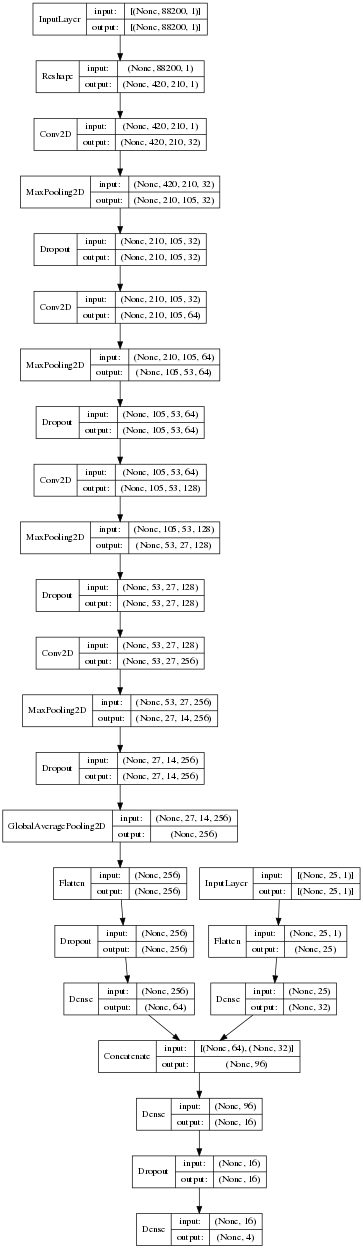

In [198]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=50
)

In [199]:
model_loss_path = 'model_loss.h5'
model_acc_path = 'model_acc.h5'
check_pt_loss = tf.keras.callbacks.ModelCheckpoint(model_loss_path, monitor='val_loss', verbose=0, save_best_only=True, save_weight_only=False)
check_pt_acc = tf.keras.callbacks.ModelCheckpoint(model_acc_path, monitor='val_loss', verbose=0, save_best_only=True, save_weight_only=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [161]:
'''shuffler1 = np.random.permutation(y_train_class.shape[0])
x_audio_train_new = x_audio_train[shuffler1]
x_feat_train_new = x_feat_train[shuffler1]
y_train_class_new = y_train_class[shuffler1]
print(x_audio_train_new.shape)
print(x_feat_train_new.shape)
print(y_train_class_new.shape)'''

(6674, 88200)
(6674, 25)
(6674, 4)


In [200]:
history = model.fit(
                    [x_audio_train, x_feat_train],
                    y_train_class,
                    validation_data=([x_audio_val, x_feat_val], y_val_class),
                    shuffle=True,
                    epochs=100,
                    batch_size=16,
                    verbose=1,
                    callbacks=[check_pt_loss, check_pt_acc]
                    )

Epoch 1/100
321/321 [==============================] - 16s 47ms/step - loss: 380.6424 - accuracy: 0.2585 - val_loss: 70.0999 - val_accuracy: 0.1982
Epoch 2/100
321/321 [==============================] - 14s 43ms/step - loss: 77.2980 - accuracy: 0.2760 - val_loss: 30.8327 - val_accuracy: 0.2428
Epoch 3/100
321/321 [==============================] - 14s 43ms/step - loss: 69.5952 - accuracy: 0.2786 - val_loss: 29.6740 - val_accuracy: 0.2874
Epoch 4/100
321/321 [==============================] - 14s 42ms/step - loss: 62.7562 - accuracy: 0.3098 - val_loss: 61.6140 - val_accuracy: 0.2874
Epoch 5/100
321/321 [==============================] - 14s 43ms/step - loss: 39.7420 - accuracy: 0.3426 - val_loss: 19.4365 - val_accuracy: 0.4372
Epoch 6/100
321/321 [==============================] - 14s 43ms/step - loss: 38.6589 - accuracy: 0.3675 - val_loss: 76.6192 - val_accuracy: 0.4501
Epoch 7/100
321/321 [==============================] - 14s 42ms/step - loss: 28.1711 - accuracy: 0.4056 - val_loss: 2

In [201]:
# load back best model
best_model = tf.keras.models.load_model(model_loss_path)

# Estimation

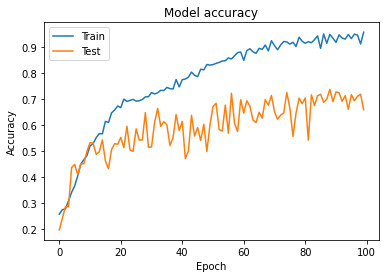

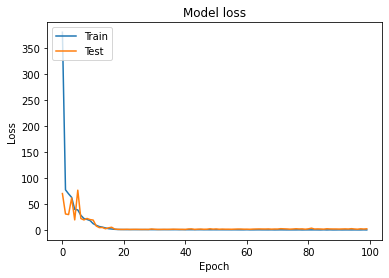

In [202]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [203]:
pre = best_model.predict([x_audio_test, x_feat_test])
print(pre[1])
pre=np.argmax(pre,axis=1)

[0.06700403 0.00096231 0.19631626 0.7357175 ]


In [204]:
eva = best_model.evaluate([x_audio_test, x_feat_test], y_test_class)
print(eva)

25/25 [==============================] - 1s 26ms/step - loss: 0.9909 - accuracy: 0.6439
[0.9908545017242432, 0.6439393758773804]


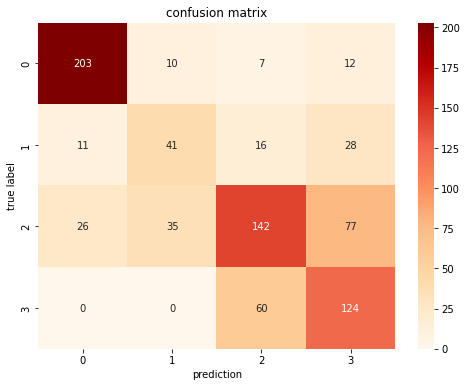

In [205]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test_class,axis=1), pre)
fit = plt.figure(figsize=(8,6))
plt.title('confusion matrix')
sn.heatmap(cm,annot=True,cmap='OrRd',fmt='g')
plt.xlabel('prediction')
plt.ylabel('true label')
plt.show()